# TDA Tutorial 1: Graph Representations
By: David Cole and Victor M. Zavala

Based on work done by Dr. Alexander Smith, as outlined in [this paper](https://www.sciencedirect.com/science/article/pii/S0098135421002416?via%3Dihub). Code for creating the visualizations was constructured with the help of ChatGPT

If you are running this notebook (and the other TDA notebooks) on Google Drive, you will need to specify a path and mount the notebook to your google drive. The following cell performs this function. You will have to specify the path and make sure the data is available in your path. For this notebook, I did this by adding a shortcut from the GoogleCollabCBE660/Python folder to my own Google Drive so that I can call that data directly.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Topological Data Analysis (TDA)

TDA considers the "shape" of data. The shape of the data can encode useful information about the dataset. TDA provides different approaches for analyzing shape and retrieving information about the data or features that describe the data. In this tutorial, we outline how certain datasets can be modeled as a graph.

For further reading on TDA, we recommend the following papers:
 * [The Euler characteristic: A general topological descriptor for complex data](https://doi.org/10.1016/j.compchemeng.2021.107463)
 * [Topological data analysis: Concepts, computation, and applications in chemical engineering](https://doi.org/10.1016/j.compchemeng.2020.107202)
 * [The shape of complex systems](https://www.nature.com/articles/s44286-024-00101-w)

## The Euler Characteristic (EC)

The EC is a scalar descriptor that describes the topology of an object. An n-dimensional object is made up of n different topological bases that can describe the object. For example, for a 2D object, there are two topological bases: the number of connected components and the number of holes. The EC, $\chi$, is given by:

$$ \chi = \sum^{n-1}_{i = 0} (-1)^i \beta_i $$

where $\beta_i$ is the $i$th betti number, or the number of topological bases of the $i$th rank. For instance, $\beta_0$ is the number of connected components in an object and $\beta_1$ is the number of holes in the object.

While the EC is a scalar value, it can often be informative to see how the EC changes as an object is filtered. Filtration is a process whereby parts of an object (e.g., vertices, faces) are filtered out or removed if they do not meet a certain criteria (e.g., weighted vertices are removed whose value is greater than some threshold value). For a given threshold value, an object can be filtered and the EC recomputed. This is repeated at different threshold values and results in an EC curve.

## Graph Theory

Graphs (sometimes referred to as networks) are collections of nodes and edges, where an edge is a link between two nodes. Graphs can be used for representing systems because nodes can represent many things (e.g., ideas, process systems components, atoms). Graphs are topological objects and are "topologically invariant", meaning the orientation of the graph does not change its topological descriptors - you can position nodes in a Euclidean space in any way and the topology of the graph (and its topological descriptors) remain unchanged

For a graph, the Euler characteristic is equal to the number of connected components in the graph minus the number of cycles in the graph. This value is also equal to the number of nodes minus the number of edges

$$\chi = |\mathcal{N}| - |\mathcal{E}|$$

## Modeling data as Graphs

Many datasets can be represented as graphs. For instance, matrices can be modeled as a node-weighted graph by representing each matrix entry as a node and adding edges between adjacent matrix entries, as in the figure below. The value of the matrix entry can be stored as a "node weight" within the graph. Similarly, images can be represented as a graph by the same approach, where each pixel is represented by a node and the light intensity at that pixel is saved as a node weight in the graph.


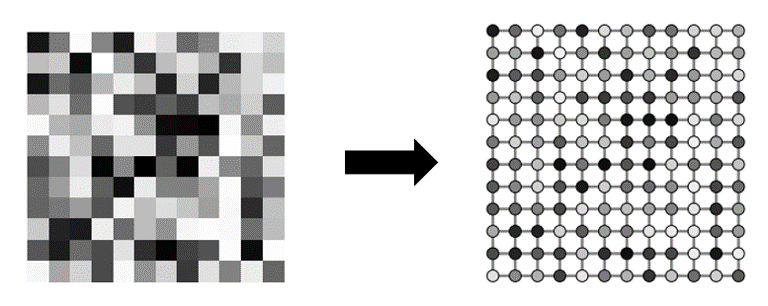


Symmetric matrices can also be represented as an edge-weighted graph. In this case, for an $n \times n$ symmetric matrix, the graph is represented by $n$ nodes with edges between every node. Here, the $i, j$th entry of the matrix corresponds to an edge weight between node $i$ and node $j$, as shown in the figure below. This is the approach that will be taken in the tutorial below.

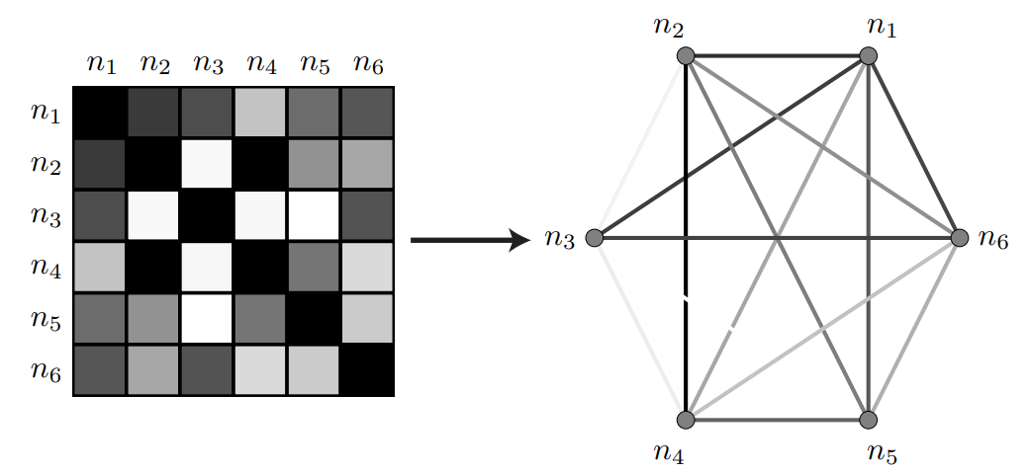

In the analysis below, we will compute the EC of different graphs. Graphs are 2-D objects, so the EC of a graph is described by two betti numbers, the number of connected components and the number of cycles. For graphs, this is equal to the number of nodes minus the number of edges in the graph.


In Python, NetworkX is the most common package used for creating graph-based representations. However, NetworkX has some limitations and some TDA metrics can require hardcoding the graph or functionality (e.g., to our knowledge, filtration is not implemented directly in NetworkX without some extra work by the user). However, in the example below, we do not have to directly construct the graph to perform TDA, as will be shown. Further reading on graph-based modeling of data (as well as the images above) can be found [here](https://doi.org/10.1016/j.compchemeng.2024.108679).

## Example: EC for Identifying Brain Activity

The example below comes from [this paper](https://doi.org/10.1016/j.compchemeng.2021.107463). In this example, we look at the correlation matrix for several multi-variate time series, where the time series were collected at different locations of the brains. There are 30 different multi-variate time series, 6 adults (developed brains) and 24 children (underdeveloped brains), which were obtained while the participant watched a short film and the brain activity at different brain regions were measured. An example of the multi-variate time sereies considered is shown below, where there are 39 different variables (brain locations)


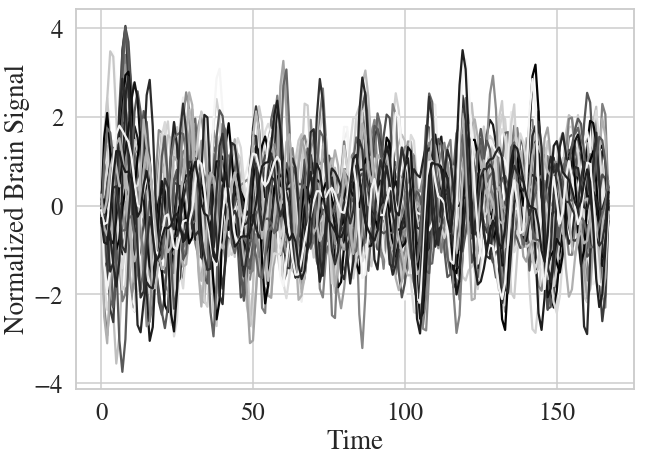


(image from [The Euler characteristic: A general topological descriptor for complex data](https://doi.org/10.1016/j.compchemeng.2021.107463))

The correlation matrix for these MVS is computed, and we will load in these precomputed correlation matrices in the code below

In [ ]:
# Load in basic packages
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Load in data
data = np.load("./Data/brains.pickle",allow_pickle = True)

In [ ]:
# Print the shape of the data
# First dimension is the number of datasets and the last two are the actual correlation matrix
np.shape(data)

(30, 39, 39)

Below is an example of a single correlation matrix

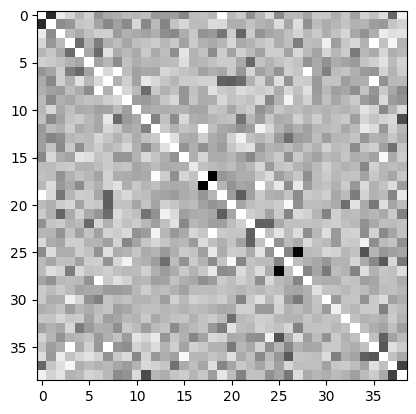

In [ ]:
# Plot a single correlation matrix
plt.imshow(data[1],vmax = .02,cmap = "gray")
plt.grid(False)

With the data loaded, we can now define a function for computing the EC at different threshold values. In this case, we are considering the symmetric matrix representation outlined above. Each matrix entry corresponds to a single edge, and we will filter out edges based on their weight (the matrix entry value). The number of nodes does not change at any filtration values. Because of this, we can actually simplify the computation of the EC since we only need to count the number of edges in the graph, where the number of edges correlates to the number of entries that do not meet a criteria. In the `euler_char` function below, we consider the correlation matrix, `A`, and a range of threshold values, `thresh`. The function will loop through the threshold values and remove all edges whose value is greater than threshold value. Thus, the only thing we actually need to count is the number of entries in the matrix whose value is less than the threshold value (since the matrix is symmetric, we also divide this value by two to account for double counting edges).

In [ ]:
# Define a function for getting the EC curve
def euler_char(A,thresh):
    # Create a list for saving the ECs
    ECs = []
    # subtract an identity matrix from the diagonal of the correlation matrix
    # this ensures that none of the diagonal elements are counted as edges
    A = A - np.identity(np.shape(A)[0])

    # Loop through the threshold values
    for t in thresh:

        # Create a new array with a `1` where any of the original matrix's entries were less than the threshold value
        M = np.array((A <= t)*1)

        # Count the number of edges
        Edges = np.sum(M)/2

        # Count the number of nodes
        Nodes = np.shape(A)[0]

        # Compute the EC
        EC = Nodes - Edges

        # Append the EC to the list
        ECs.append(EC)

    # Return the EC after finishing the loop
    return ECs

In [ ]:
# Define the threshold range
thresh = np.linspace(0,.2,1000)

# Define a list for the EC curves
ECs = []

# Compute the EC curve for each dataset
for i in range(30):
    ECs.append(euler_char(np.absolute(data[i,:,:]),thresh))

We can now visualize the results. We will first plot all 30 EC curves and then plot the average of the developed vs. underdeveloped brains. It is clear from the visuals that there is a very clear difference in the EC between the developed and underdeveloped brains. What's more, these EC curves were able to be computed very rapidly.

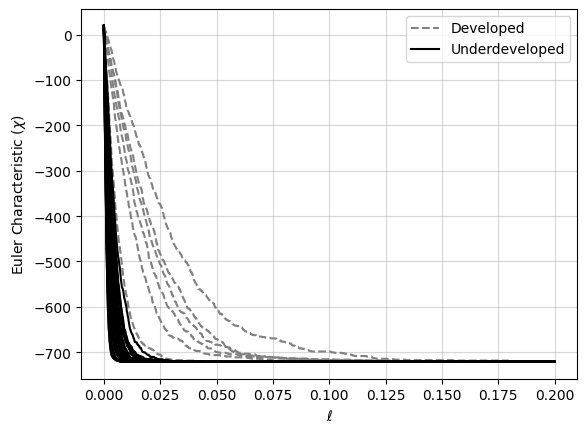

In [ ]:
ECv = np.vstack(ECs)

plt.figure()
plt.plot(thresh, ECv[0], label = "Developed", color = "gray", ls = '--')
plt.plot(thresh, ECv[6], label = "Underdeveloped", color = "black", ls = '-')
for i in range(5):
    plt.plot(thresh, ECv[i + 1], label = None, ls = '--', color = "gray")

for i in range(23):
    plt.plot(thresh, ECv[i + 7], label = None, ls = '-', color = "black")

plt.legend()
plt.xlabel("$\ell$")
plt.ylabel("Euler Characteristic ($\chi$)")
plt.grid(alpha = 0.5)

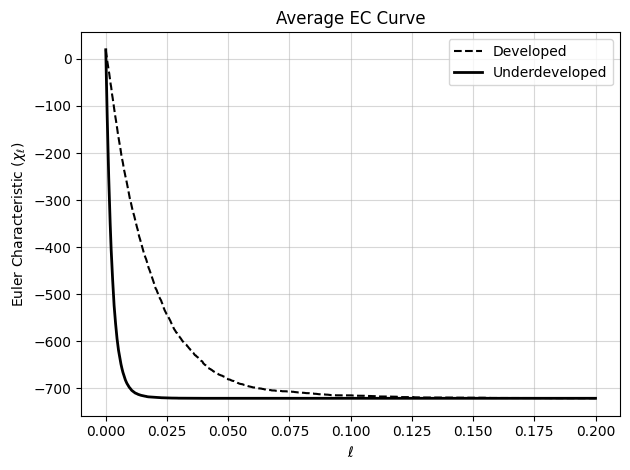

In [ ]:
adult = np.mean(ECs[0:6],axis = 0)
child = np.mean(ECs[6::],axis = 0)

plt.plot(thresh,adult,'--', label = "Developed",c = 'k')
plt.plot(thresh,child, label = "Underdeveloped",c = 'k', linewidth = 2)

plt.title("Average EC Curve")
plt.xlabel("$\ell$")

plt.ylabel(r"Euler Characteristic ($\chi_{\ell}$)")

plt.legend()

plt.grid(alpha = 0.5)
plt.tight_layout()

## NetworkX Overview

In the above example, directly constructing the graph was not necessary since we could count the number of edges based on the matrix data. Below, we will show how we can build this problem using NetworkX in Python. We will first build a simple graph structure, will show how to build the above edge weighted graph in NetworkX, and will then show how to construct an image as a graph.

If you do not have NetworkX installed, you can uncomment and run the code below:

In [ ]:
#!pip install networkx

In NetworkX, a graph is first instantiated, and then nodes and edges can be added to the graph. Nodes can be named anything, and adding an edge with a node not in the graph will result in the nodes being added to the graph

In [ ]:
import networkx as nx

# Instantiate an undirected graph
G = nx.Graph()

# Add two nodes to the graph
G.add_node(1)
G.add_node(2)

# Add two new nodes with an edge between them
G.add_edge(3, 4)

# Add three more edges
G.add_edge(2, 4)
G.add_edge(1, 4)
G.add_edge(1, 2)

We can also add attributes to the nodes as shown below. This creates a dictionary on each node, so each node does not have to include the same attribute. The same approach can be taken for setting data on edges.

In [ ]:
# Add attributes to the graph
G.nodes[1]["attribute1"] = np.random.rand()
G.nodes[2]["attribute1"] = np.random.rand()
G.nodes[3]["attribute1"] = np.random.rand()
G.nodes[4]["attribute1"] = np.random.rand()

# Query an attribute on the nodes
print("Attribute 1 on node 1 is ", G.nodes[1]["attribute1"])

Attribute 1 on node 1 is  0.8559391957772094


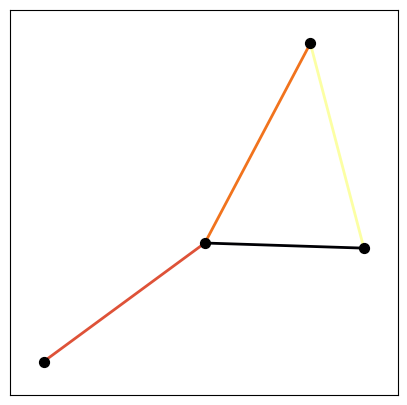

In [ ]:
# Add data to the edges
for u, v in G.edges():
    G.edges[u, v]['attribute1'] = np.random.random()

# Plot the graph with the edges colored by the edge weight
plt.figure(figsize=(5, 5))
pos = nx.spring_layout(G)  # Position nodes using the spring layout

# Extract values for coloring edges
edge_weights = [G.edges[u, v]['attribute1'] for u, v in G.edges()]


# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_color='black', node_size=50)

# Draw edges with colors based on edge weights
edges = nx.draw_networkx_edges(
    G, pos, edge_color=edge_weights, edge_cmap=plt.cm.inferno, width=2
)

We will not build the edge weighted graph from the EC examples and visualize the graph. We will also show some example code for extracting the EC from an edge-filtration process. Note that we use nx.complete_graph to build a graph with edges between every node.

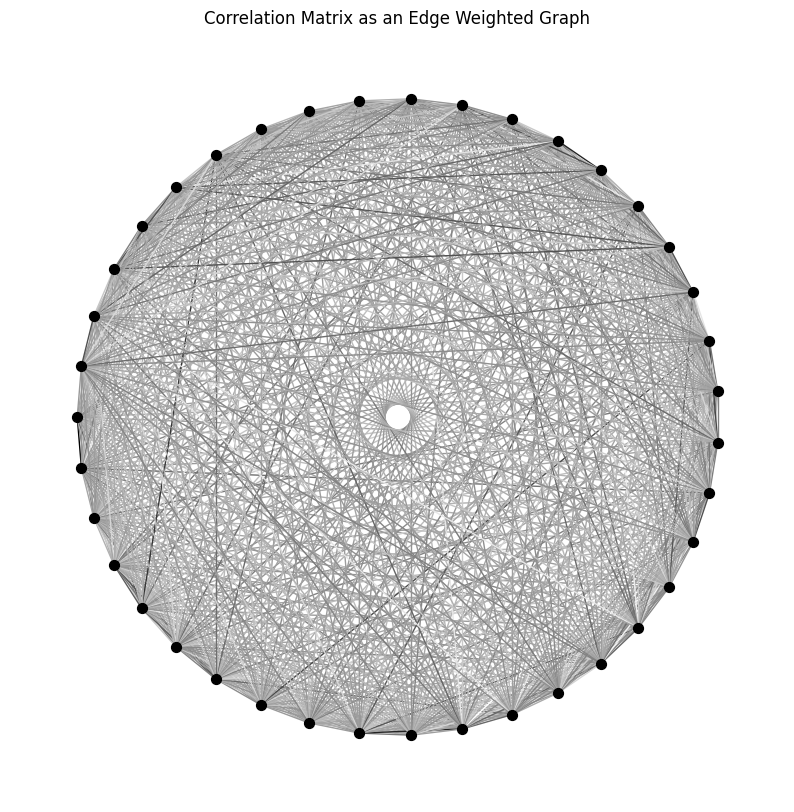

In [ ]:
# Create a complete graph with 39 nodes
G = nx.complete_graph(39)

# Add matrix data to the edges
for i in range(0, 38, 1):
    for j in range(i + 1, 39, 1):
        G.edges[i, j]["weight"] = data[0, i, j]

# Extract edge weights for coloring
edge_weights = [G.edges[u, v]['weight'] for u, v in G.edges()]

# Plot the graph
plt.figure(figsize=(10, 10))
pos = nx.shell_layout(G)  # Position nodes using the spring layout

# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_color='k', node_size=50)

# Draw edges with colors based on edge weights
edges = nx.draw_networkx_edges(
    G, pos, edge_color=edge_weights, edge_cmap=plt.cm.gray, width=1
)

# Draw labels (optional, but may be cluttered due to number of nodes)
#nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Correlation Matrix as an Edge Weighted Graph")
plt.axis("off")
plt.show()


We could alternatively represent this same matrix as a graph using the code below. Note that we create each node by defining edges between each matrix entry rather than calling `add_node`. We will name each node the index of the matrix entry the node corresponds to (i.e., names will be tuples called (i, j)).

In [ ]:
# Instantiate the graph
G = nx.Graph()

# Define the matrix; we will subtract a diagonal matrix to scale values here,
# but this is purely for visualization later
matrix = data[0, :, :] - 0.5 * np.identity(np.shape(data[0, :, :])[0])
d1, d2 = matrix.shape

# Loop through the dimensions and add edges between corresponding matrix entries
for i in range(d1):
    for j in range(d2 - 1):
        G.add_edge((i, j), (i, j + 1))
        if (i != d1 - 1):
            G.add_edge((i, j), (i + 1, j))

# Add edges between the last set of nodes at j = 38 (the last row of the matrix)
for i in range(d1 -1):
    G.add_edge((i, 38), (i + 1, 38))

# Add a weight value on each node based on the matrix entry
for i in range(d1):
    for j in range(d2):
        G.nodes[(i, j)]["weight"] = matrix[i, j]

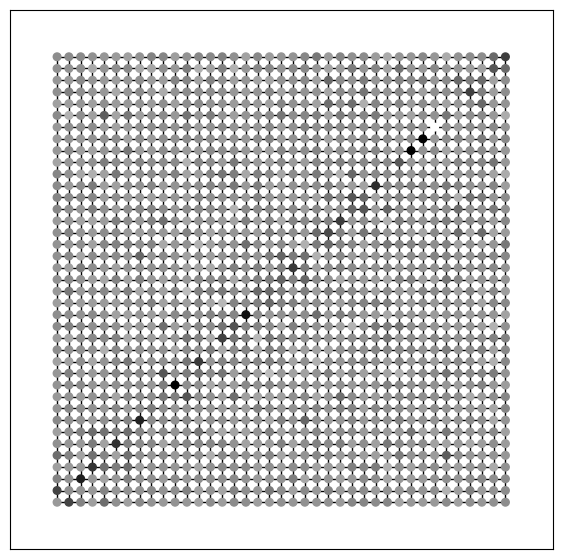

In [ ]:
# Plot the graph
plt.figure(figsize=(7,7))

# Set the x and y positions to be equal to the matrix positions
x_positions = [i[0] for i in G.nodes]
y_positions = [i[1] for i in G.nodes]

# Create a dictionary of positions from x_positions and y_positions
positions = {node: (x_positions[i], y_positions[i]) for i, node in enumerate(G.nodes)}

# Get the node weights for coloring nodes
node_weights = [G.nodes[node]["weight"] for node in G.nodes]

# Draw the nodes
nx.draw_networkx_nodes(G, positions, node_size=30, node_color=node_weights, cmap=plt.cm.gray)

# Draw edges with colors based on edge weights
edges = nx.draw_networkx_edges(
    G, positions
)

Filtration is not automatically implemented in NetworkX to our knowledge. However, NetworkX can return a subgraph of the original graph. In this case, we can create the subgraph by passing the set of nodes we want to keep, and NetworkX will then also keep all the edges which go between those nodes. We will remove all nodes whose value is less than 0, and then plot the remaining graph. We will also compute the EC on this new graph, since the EC is just the number of nodes minus the number of edges. This approach could be applied to image analysis, but we will show in the next tutorial how images can also be analyzed with cubical complexes.

The EC of the subgraph is  83


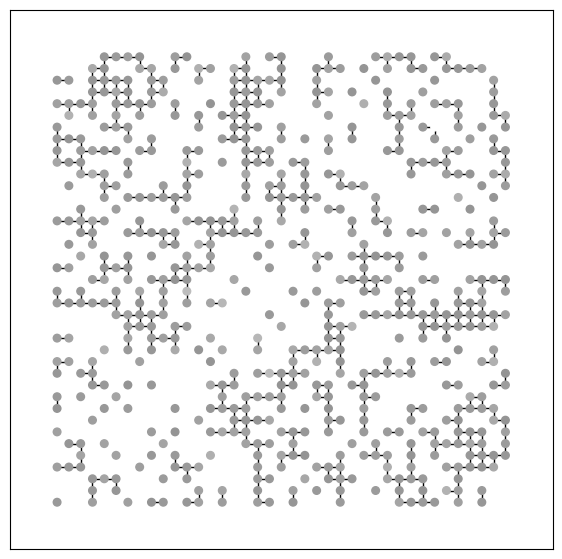

In [ ]:
# Define the set of nodes to keep
nodes_to_keep = [node for node in G.nodes if G.nodes[node]["weight"] >= 0]

# Induce a subgraph based on this set of nodes
SG = G.subgraph(nodes_to_keep)

# Plot the new graph
plt.figure(figsize=(7,7))

x_positions = [i[0] for i in SG.nodes]
y_positions = [i[1] for i in SG.nodes]

# Create a dictionary of positions from x_positions and y_positions
positions = {node: (x_positions[i], y_positions[i]) for i, node in enumerate(SG.nodes)}
node_weights = [SG.nodes[node]["weight"] for node in SG.nodes]

# Draw the nodes
nx.draw_networkx_nodes(SG, positions, node_size=30, node_color=node_weights, cmap=plt.cm.gray, vmin = np.min(matrix))

# Draw edges with colors based on edge weights
edges = nx.draw_networkx_edges(
    SG, positions
)

# Compute the EC for this new graph
print("The EC of the subgraph is ", len(SG.nodes) - len(SG.edges))